In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from perspective import CalibratedPerception
from object_detect import segment_navigable
from object_detect import segment_rock_sample
from rover_state import RoverState
from collections import namedtuple
from perception import render_particles
from perception import render_rays
from ray_detect import particle_to_rays
from geometry import to_polar_coords
from object_detect import detect_directions
from object_detect import detect_obstacles

In [67]:
perception = CalibratedPerception()
df = pd.read_csv('../new_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)
def next_state(idx=None):
    if idx is None:
        idx = np.random.randint(0, len(df['Path']))
    print('current idx', idx)
    ret = RoverState()
    ret.img = plt.imread(df['Path'][idx])
    ret.pos = (df["X_Position"][idx], df["Y_Position"][idx])
    ret.yaw = df['Yaw'][idx]
    ret.roll = df['Roll'][idx]
    ret.pitch = df['Pitch'][idx]
    return ret

current idx 1326


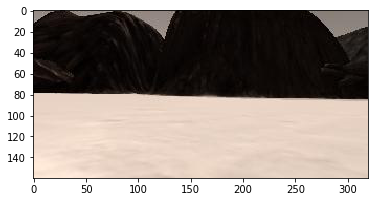

In [131]:
state = next_state()
navigable = segment_navigable(state.img)
plt.imshow(state.img)
plt.show()

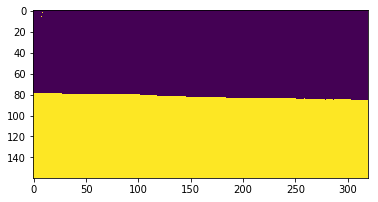

In [132]:
plt.imshow(navigable)
plt.show()

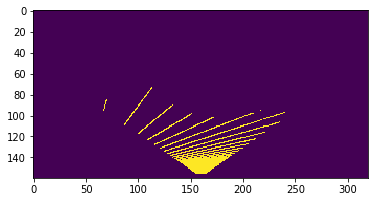

In [133]:
w_coords, b_coords = perception.evaluate(navigable, state)
particle_render = render_particles(b_coords)
plt.imshow(particle_render)
plt.show()

In [134]:
r, theta = to_polar_coords(b_coords[0], b_coords[1])
rays = particle_to_rays(r, theta, np.pi/3, min_dist=0.5, max_dist=9.8)

vote_dims: -0.951204442337 6.42602010486 9.23420014941 6
project_dim 4.27367845332 5.17482912341
num_segs: 1
vote_dims: -0.942477796077 4.9430135098 9.15649078616 16
project_dim 3.67523370664 5.1839955682
num_segs: 1
vote_dims: -0.933751149817 4.02639301916 9.00332936519 27
project_dim 3.23866592626 5.17159451201
num_segs: 1
vote_dims: -0.925024503557 3.40382441401 8.77910368313 39
project_dim 2.90626461201 5.1377932314
num_segs: 1
vote_dims: -0.916297857297 2.95344800795 8.56130329348 50
project_dim 2.64483629838 5.10369935225
num_segs: 1
vote_dims: -0.907571211037 2.61256404917 8.41956961225 60
project_dim 2.43393505428 5.0901471804
num_segs: 1
vote_dims: -0.898844564777 2.3343645367 8.21202225403 73
project_dim 2.25187732486 5.05543062501
num_segs: 1
vote_dims: -0.890117918517 2.0386437846 9.79693182543 86
project_dim 2.04196761168 5.52188369045
num_segs: 1
vote_dims: -0.881391272257 1.87771518821 9.79693182543 97
project_dim 1.92815898133 5.54828044058
num_segs: 1
vote_dims: -0.872

num_segs: 1
vote_dims: 0.383972435439 0.54346754471 7.48199491344 249
project_dim 0.915523268535 5.81140775759
num_segs: 1
vote_dims: 0.392699081699 0.545244987622 7.46403728554 250
project_dim 0.915269655979 5.79686104267
num_segs: 1
vote_dims: 0.401425727959 0.547062043879 7.44670945989 265
project_dim 0.914993300067 5.78227503109
num_segs: 1
vote_dims: 0.410152374219 0.548918189586 7.42999668974 255
project_dim 0.914692341174 5.76764482392
num_segs: 1
vote_dims: 0.418879020479 0.550812899884 7.3983588806 244
project_dim 0.91436490997 5.74784270073
num_segs: 1
vote_dims: 0.427605666739 0.552745649333 7.38340588187 258
project_dim 0.914009128756 5.73328359809
num_segs: 1
vote_dims: 0.436332312999 0.554715912285 7.36901200755 259
project_dim 0.91362311276 5.71866232953
num_segs: 1
vote_dims: 0.445058959259 0.556723163237 7.35516400982 263
project_dim 0.913204971392 5.70397382737
num_segs: 1
vote_dims: 0.453785605519 0.558766877188 7.34184892366 266
project_dim 0.91275280946 5.689212982

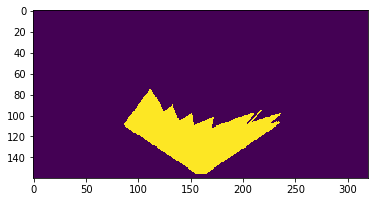

In [135]:
ray_render = render_rays(rays)
plt.imshow(ray_render)
plt.show()

In [149]:
-

In [150]:
directions = detect_directions(rays)

In [151]:
filter_rays = [r for r in rays if len(r.segments) == 1]
filter_rays = [r for r in rays if r.segments[0, 1] > DIRECTION_DROP_RADIUS]

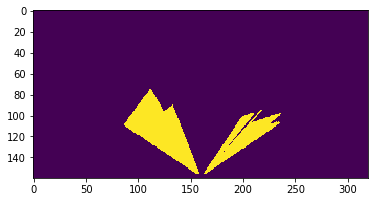

In [152]:
render_filter = render_rays(filter_rays)
plt.imshow(render_filter)
plt.show()

In [153]:
def render_directions(directions):

  RenderRay = namedtuple('RenderRay', ('theta', 'segments'))

  ret = []
  for direction in directions:
    augmented = np.linspace(direction - 0.02, direction + 0.02, 10)
    segments = np.array([[0.0, 10.0]])
    rays = [RenderRay(theta=x, segments=segments) for x in augmented]
    ret.extend(rays)

  render = render_rays(ret)
  return render

In [154]:
direction_render = render_directions(directions)

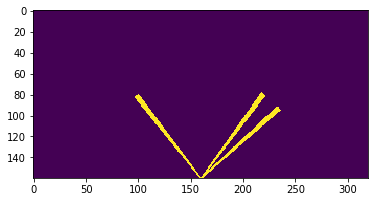

In [155]:
plt.imshow(direction_render)
plt.show()

In [19]:
obstacles = detect_obstacles(rays)

In [20]:
obstacles

[array([ 1.83458892, -2.34816673]),
 array([ 1.92552434, -2.42071586]),
 array([ 1.93632206, -2.3911586 ]),
 array([ 1.94680081, -2.36165823]),
 array([ 1.93636788, -2.30767338]),
 array([ 1.9358267 , -2.26656185]),
 array([ 2.03573806, -2.34184875]),
 array([ 2.04494379, -2.31138848]),
 array([ 2.04269152, -2.26863876]),
 array([ 2.05122203, -2.23851603]),
 array([ 2.03716215, -2.18458895]),
 array([ 2.02288111, -2.13167191]),
 array([ 2.14347377, -2.21963206]),
 array([ 2.16276185, -2.20084245]),
 array([ 2.15769448, -2.15769448]),
 array([ 2.1643533 , -2.12690406]),
 array([ 2.14671146, -2.07305516]),
 array([ 2.28333358, -2.16680266]),
 array([ 2.30215532, -2.14679456]),
 array([ 2.29451995, -2.10254016]),
 array([ 2.29967178, -2.07063377]),
 array([ 2.27857326, -2.01591133]),
 array([ 2.44929022, -2.12913551]),
 array([ 2.46777694, -2.10768062]),
 array([ 2.45738354, -2.06198962]),
 array([ 2.46100056, -2.02869231]),
 array([ 2.43612877, -1.97273818]),
 array([ 2.43921842, -1.9402

In [51]:
directions

[-0.66758843888783104,
 -0.37088246604879493,
 -0.0087266462599715419,
 0.19198621771937635,
 0.51487212933832716,
 0.72867496270763266,
 0.79218555493298193]

In [156]:
detect_obstacles(rays)

[array([ 5.31720126, -7.45444124]),
 array([ 5.38205025, -7.40775665]),
 array([ 5.35538546, -7.23738808]),
 array([ 5.28339649, -7.01130395]),
 array([ 5.21179123, -6.79213857]),
 array([ 5.18360465, -6.6347114 ]),
 array([ 5.0698583 , -6.37368542]),
 array([ 6.10838079, -7.54322206]),
 array([ 6.23161496, -7.55955344]),
 array([ 6.06828964, -7.23190598]),
 array([ 6.07493926, -7.11284   ]),
 array([ 6.02509116, -6.93107452]),
 array([ 5.97506649, -6.75358411]),
 array([ 5.76611085, -6.40391488]),
 array([ 5.82177529, -6.35335286]),
 array([ 5.77209478, -6.18981383]),
 array([ 5.67146058, -5.97647244]),
 array([ 5.57270848, -5.77070856]),
 array([ 5.5732982 , -5.67142945]),
 array([ 5.57314076, -5.57314076]),
 array([ 5.52349194, -5.42792041]),
 array([ 5.42638994, -5.24020385]),
 array([ 5.4245031 , -5.14766123]),
 array([ 5.37521913, -5.01247293]),
 array([ 5.32611227, -4.88048271]),
 array([ 5.27720975, -4.751621  ]),
 array([ 6.51558092, -5.76449906]),
 array([ 5.22416276, -4.5412